# Navigation: The Banana Project
---
This project trains three different Deep Q-Network (DQN) based agents, each of which implements a different learning strategy, and compares their training performance.  The learning strategies implemented in this project are:
1. Fixed Q-Targets
2. Experience Replay
3. Double Q-Learning
4. Prioritized Experience Replay

Code for each agent is in the `pi_navigation/agent` directory, and the file nomenclature used to identify each implementation uses the item number of the learning strategy list above

- **dqn_agent_1_2**: Implements Fixed Q-Targets and Experience Replay
- **dqn_agent_1_2_3**: Implements Fixed Q-Targets, Experience Replay, and Double Q-Learning
- **dqn_agent_1_3_4**: Implements Fixed Q-Targets, Prioritized Experience Replay, and Double Q-learning

## Table of Contents
- Initialize notebook setings
- Training Process
  - Training one agent
  - Training all agents
- All agents training performance analysis
- Let the Agent navigate

## Initialize notbook setings

In [1]:
# will automatically reload imported packages
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime as dt
from collections import namedtuple

from agent import training

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import torch

In [5]:
torch.cuda.is_available()

True

In [6]:
output_model_directory = os.path.abspath("agent_model/")
output_training_data = os.path.abspath("training_data/")

## Training Process

In [7]:
agent_info = namedtuple("Agent_info", field_names = ['agent_name', 'agent_implementation', 
                                                       'priority_replay', 'exp_replay_alpha'])

In [8]:
def run(agents, n_sessions, target_score):
  """
  Orchestrates training process for all Agents
  
  Trains each agent in agents for session, and records the best traning session
  for the agent
  
  I also keeps a log of the training data for each agent's session
  and persists it to local storage at the end of the run
  
  Args:
  - agents (iterable of Agent_info): the agents to train with respective info
  
  - n_sessions (int): the number of sessions to train each agent for
  
  - target_score (float): the target score a training session should achieve.  
    The Train function will halt learning as soon as target_score is reached
  """
  
  best_agent = dict()
  training_log = dict()
  
  for a_info in agents:
    
    cols = ['agent', 'session', 'episode', 'score', 'epsilon', 'beta']
    training_log[a_info.agent_name] = pd.DataFrame(columns = cols)
    
    # initialize best session to loose in comparison with first real outcome
    best_agent[a_info.agent_name] = {"score": -np.inf, 'episode': 3000, 'session': -1}
    
    for session in range(n_sessions):
      trainer = training.Train_Agent(agent_implementation = a_info.agent_implementation)
      
      # train
      print("{} - Training {} session {}".format(dt.now().strftime('%Y-%m-%d %H:%M:%S'), 
                                                 a_info.agent_name, session))
      agent, data = trainer.Train(target_score = target_score, 
                                  priority_replay = a_info.priority_replay, 
                                  **{'exp_replay_alpha': a_info.exp_replay_alpha}
                                 )
      
      #process session
      data['agent'] = a_info.agent_name
      data['session'] = session
      
      print("Logging {} training data rows".format(data.shape[0]))
      # return data
      
      training_log[a_info.agent_name] = pd.concat([training_log[a_info.agent_name], data[cols]], 
                                                  axis = 0, ignore_index=True)
      print("Log: {}".format(training_log[a_info.agent_name].shape))
      
      # keep track of best training session
      # Better model is defined as:
      # The set of weights of the episode that reached the best score (score.max()) 
      # from the set of averaged episodes that reached the target_score
      episode_set = data[-100:]
      if (episode_set['score'].max() > best_agent[a_info.agent_name]['score']):
        best_info = episode_set[episode_set['score'] == episode_set['score'].max()][['score', 
                                                                                     'episode']]
        best_agent[a_info.agent_name]['score'] = best_info['score'].values[0]
        best_agent[a_info.agent_name]['episode'] = best_info['episode'].values[0]
        best_agent[a_info.agent_name]['session'] = session
        
        # persist the best model weights
        torch.save(agent.dqn_local.state_dict(), 'agent_model/{}.pth'.format(a_info.agent_name))
        
        print("recorded better model for {}, score: {}, episode: {}, session: {}"
              .format(a_info.agent_name, best_agent[a_info.agent_name]['score'], 
                      best_agent[a_info.agent_name]['episode'], session))
        
  return training_log, best_agent
      

### Training one agent

In [9]:
# training context

target_score = 13.0
n_sessions = 1
agents = [
  agent_info('dqn_agent_1_2', 'dqn_agent_1_2', False, 0), 
]

In [10]:
training_log, best_agent = run(agents, n_sessions, target_score)

2023-03-08 07:26:13 - Training dqn_agent_1_2 session 0


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 07:29:04 - Episode: 100	Average Score: 0.84	eps: 0.6088	beta: 0.000000
2023-03-08 07:31:48 - Episode: 200	Average Score: 5.01	eps: 0.3688	beta: 0.000000
2023-03-08 07:34:39 - Episode: 300	Average Score: 7.36	eps: 0.2234	beta: 0.000000
2023-03-08 07:37:26 - Episode: 400	Average Score: 9.37	eps: 0.1353	beta: 0.000000
2023-03-08 07:40:14 - Episode: 500	Average Score: 11.58	eps: 0.0820	beta: 0.000000
Episode: 582	Average Score: 13.00	eps: 0.0544	beta: 0.000000
2023-03-08 07:42:31 - Environment solved in:
Episode: 582	Average Score: 13.00	eps: 0.0544	beta: 0.000000
Logging 582 training data rows
Log: (582, 6)
recorded better model for dqn_agent_1_2, score: 23.0, episode: 531, session: 0


In [11]:
agent = list(training_log.keys())[0]
data = training_log[agent]
data.shape

(582, 6)

Visualize the learning data

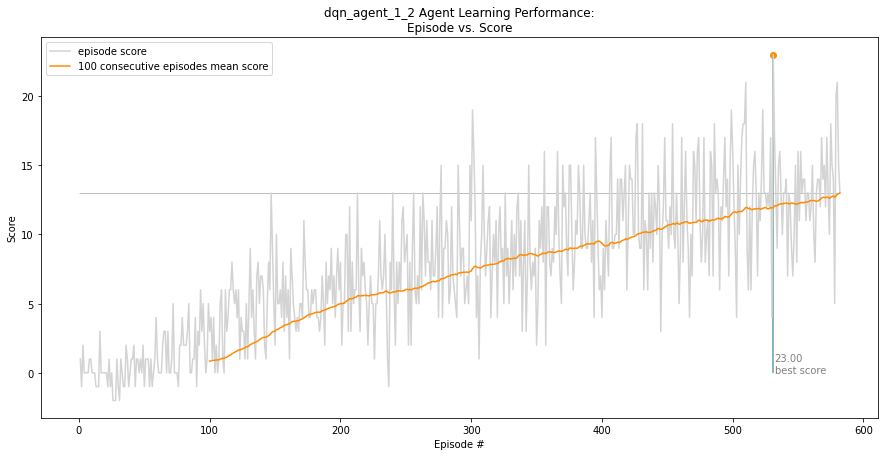

In [12]:
# plot the learning data
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot()

ax.plot(data['episode'], data['score'], color = 'LightGray', 
        label = 'episode score'
       )
ax.plot(data['episode'], data['score'].rolling(window = 100).mean(), color = 'DarkOrange', 
        label = "100 consecutive episodes mean score"
       )

ax.hlines(y = target_score, xmin = 0, xmax = data['episode'].max(), color = 'Gray', 
          linewidths = 0.5
         )
ax.vlines(x = best_agent[agent]['episode'], 
          ymin = 0, ymax = best_agent[agent]['score'], color = 'CadetBlue', 
          # linewidths = 0.5
         )

txt = "{:.2f}\nbest score".format(best_agent[agent]['score'])
ax.text(x = best_agent[agent]['episode'] + 1, y = 0, s = txt, color = 'Gray')
ax.scatter(x = best_agent[agent]['episode'], y = best_agent[agent]['score'], color = 'DarkOrange')

ax.set_ylabel('Score')
ax.set_xlabel('Episode #')
ax.legend()

ax.set_title("{} Agent Learning Performance:\nEpisode vs. Score\n".format(agent))
plt.show()

### Training all agents
> If the torch devide is `cpu` This will take a loooong time

In [13]:
# training context
target_score = 13.0
n_sessions = 5
agents = [
  agent_info('dqn_agent_1_2', 'dqn_agent_1_2', False, 0), 
  agent_info('dqn_agent_1_2_3', 'dqn_agent_1_2_3', False, 0), 
  agent_info('dqn_agent_1_3_4_005', 'dqn_agent_1_3_4', True, 0.05), 
  agent_info('dqn_agent_1_3_4_01', 'dqn_agent_1_3_4', True, 0.1), 
  agent_info('dqn_agent_1_3_4_02', 'dqn_agent_1_3_4', True, 0.2), 
]

In [14]:
training_log, best_agent = run(agents, n_sessions, target_score)

2023-03-08 07:42:32 - Training dqn_agent_1_2 session 0


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 07:45:21 - Episode: 100	Average Score: 1.03	eps: 0.6088	beta: 0.000000
2023-03-08 07:48:05 - Episode: 200	Average Score: 4.35	eps: 0.3688	beta: 0.000000
2023-03-08 07:50:51 - Episode: 300	Average Score: 7.45	eps: 0.2234	beta: 0.000000
2023-03-08 07:53:37 - Episode: 400	Average Score: 9.72	eps: 0.1353	beta: 0.000000
2023-03-08 07:56:24 - Episode: 500	Average Score: 11.35	eps: 0.0820	beta: 0.000000
2023-03-08 07:59:11 - Episode: 600	Average Score: 12.97	eps: 0.0497	beta: 0.000000
Episode: 655	Average Score: 13.01	eps: 0.0377	beta: 0.000000
2023-03-08 08:00:43 - Environment solved in:
Episode: 655	Average Score: 13.01	eps: 0.0377	beta: 0.000000
Logging 655 training data rows
Log: (655, 6)
recorded better model for dqn_agent_1_2, score: 20.0, episode: 589, session: 0
2023-03-08 08:00:43 - Training dqn_agent_1_2 session 1


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 08:03:35 - Episode: 100	Average Score: 0.36	eps: 0.6088	beta: 0.000000
2023-03-08 08:06:20 - Episode: 200	Average Score: 2.96	eps: 0.3688	beta: 0.000000
2023-03-08 08:09:06 - Episode: 300	Average Score: 6.73	eps: 0.2234	beta: 0.000000
2023-03-08 08:11:54 - Episode: 400	Average Score: 10.10	eps: 0.1353	beta: 0.000000
2023-03-08 08:14:48 - Episode: 500	Average Score: 12.64	eps: 0.0820	beta: 0.000000
Episode: 538	Average Score: 13.04	eps: 0.0678	beta: 0.000000
2023-03-08 08:15:51 - Environment solved in:
Episode: 538	Average Score: 13.04	eps: 0.0678	beta: 0.000000
Logging 538 training data rows
Log: (1193, 6)
recorded better model for dqn_agent_1_2, score: 22.0, episode: 470, session: 1
2023-03-08 08:15:51 - Training dqn_agent_1_2 session 2


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 08:18:43 - Episode: 100	Average Score: 0.19	eps: 0.6088	beta: 0.000000
2023-03-08 08:21:28 - Episode: 200	Average Score: 2.99	eps: 0.3688	beta: 0.000000
2023-03-08 08:24:15 - Episode: 300	Average Score: 6.60	eps: 0.2234	beta: 0.000000
2023-03-08 08:27:04 - Episode: 400	Average Score: 9.56	eps: 0.1353	beta: 0.000000
Episode: 496	Average Score: 13.08	eps: 0.0836	beta: 0.000000
2023-03-08 08:29:46 - Environment solved in:
Episode: 496	Average Score: 13.08	eps: 0.0836	beta: 0.000000
Logging 496 training data rows
Log: (1689, 6)
2023-03-08 08:29:46 - Training dqn_agent_1_2 session 3


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 08:32:35 - Episode: 100	Average Score: 0.65	eps: 0.6088	beta: 0.000000
2023-03-08 08:35:20 - Episode: 200	Average Score: 3.79	eps: 0.3688	beta: 0.000000
2023-03-08 08:38:07 - Episode: 300	Average Score: 7.39	eps: 0.2234	beta: 0.000000
2023-03-08 08:40:55 - Episode: 400	Average Score: 11.06	eps: 0.1353	beta: 0.000000
2023-03-08 08:43:43 - Episode: 500	Average Score: 12.01	eps: 0.0820	beta: 0.000000
Episode: 519	Average Score: 13.03	eps: 0.0745	beta: 0.000000
2023-03-08 08:44:15 - Environment solved in:
Episode: 519	Average Score: 13.03	eps: 0.0745	beta: 0.000000
Logging 519 training data rows
Log: (2208, 6)
recorded better model for dqn_agent_1_2, score: 23.0, episode: 503, session: 3
2023-03-08 08:44:15 - Training dqn_agent_1_2 session 4


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 08:47:04 - Episode: 100	Average Score: 1.04	eps: 0.6088	beta: 0.000000
2023-03-08 08:49:51 - Episode: 200	Average Score: 4.06	eps: 0.3688	beta: 0.000000
2023-03-08 08:52:37 - Episode: 300	Average Score: 7.81	eps: 0.2234	beta: 0.000000
2023-03-08 08:55:26 - Episode: 400	Average Score: 9.83	eps: 0.1353	beta: 0.000000
2023-03-08 08:58:14 - Episode: 500	Average Score: 12.65	eps: 0.0820	beta: 0.000000
Episode: 506	Average Score: 13.01	eps: 0.0796	beta: 0.000000
2023-03-08 08:58:24 - Environment solved in:
Episode: 506	Average Score: 13.01	eps: 0.0796	beta: 0.000000
Logging 506 training data rows
Log: (2714, 6)
2023-03-08 08:58:24 - Training dqn_agent_1_2_3 session 0


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 09:01:22 - Episode: 100	Average Score: 0.89	eps: 0.6088	beta: 0.000000
2023-03-08 09:04:14 - Episode: 200	Average Score: 3.61	eps: 0.3688	beta: 0.000000
2023-03-08 09:07:07 - Episode: 300	Average Score: 7.37	eps: 0.2234	beta: 0.000000
2023-03-08 09:10:02 - Episode: 400	Average Score: 10.34	eps: 0.1353	beta: 0.000000
2023-03-08 09:12:57 - Episode: 500	Average Score: 11.90	eps: 0.0820	beta: 0.000000
Episode: 549	Average Score: 13.00	eps: 0.0641	beta: 0.000000
2023-03-08 09:14:22 - Environment solved in:
Episode: 549	Average Score: 13.00	eps: 0.0641	beta: 0.000000
Logging 549 training data rows
Log: (549, 6)
recorded better model for dqn_agent_1_2_3, score: 21.0, episode: 505, session: 0
2023-03-08 09:14:22 - Training dqn_agent_1_2_3 session 1


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 09:17:19 - Episode: 100	Average Score: 0.49	eps: 0.6088	beta: 0.000000
2023-03-08 09:20:11 - Episode: 200	Average Score: 3.70	eps: 0.3688	beta: 0.000000
2023-03-08 09:23:04 - Episode: 300	Average Score: 6.88	eps: 0.2234	beta: 0.000000
2023-03-08 09:26:00 - Episode: 400	Average Score: 9.48	eps: 0.1353	beta: 0.000000
2023-03-08 09:28:55 - Episode: 500	Average Score: 13.04	eps: 0.0820	beta: 0.000000

2023-03-08 09:28:55 - Environment solved in:
Episode: 500	Average Score: 13.04	eps: 0.0820	beta: 0.000000
Logging 500 training data rows
Log: (1049, 6)
2023-03-08 09:28:55 - Training dqn_agent_1_2_3 session 2


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 09:31:52 - Episode: 100	Average Score: 0.44	eps: 0.6088	beta: 0.000000
2023-03-08 09:34:44 - Episode: 200	Average Score: 3.54	eps: 0.3688	beta: 0.000000
2023-03-08 09:37:38 - Episode: 300	Average Score: 7.05	eps: 0.2234	beta: 0.000000
2023-03-08 09:40:33 - Episode: 400	Average Score: 10.82	eps: 0.1353	beta: 0.000000
Episode: 482	Average Score: 13.00	eps: 0.0897	beta: 0.000000
2023-03-08 09:42:57 - Environment solved in:
Episode: 482	Average Score: 13.00	eps: 0.0897	beta: 0.000000
Logging 482 training data rows
Log: (1531, 6)
2023-03-08 09:42:57 - Training dqn_agent_1_2_3 session 3


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 09:45:53 - Episode: 100	Average Score: 0.48	eps: 0.6088	beta: 0.000000
2023-03-08 09:48:46 - Episode: 200	Average Score: 4.04	eps: 0.3688	beta: 0.000000
2023-03-08 09:51:40 - Episode: 300	Average Score: 7.31	eps: 0.2234	beta: 0.000000
2023-03-08 09:54:36 - Episode: 400	Average Score: 11.04	eps: 0.1353	beta: 0.000000
2023-03-08 09:57:32 - Episode: 500	Average Score: 12.40	eps: 0.0820	beta: 0.000000
Episode: 563	Average Score: 13.00	eps: 0.0598	beta: 0.000000
2023-03-08 09:59:22 - Environment solved in:
Episode: 563	Average Score: 13.00	eps: 0.0598	beta: 0.000000
Logging 563 training data rows
Log: (2094, 6)
2023-03-08 09:59:23 - Training dqn_agent_1_2_3 session 4


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 10:02:19 - Episode: 100	Average Score: 0.68	eps: 0.6088	beta: 0.000000
2023-03-08 10:05:13 - Episode: 200	Average Score: 3.36	eps: 0.3688	beta: 0.000000
2023-03-08 10:08:07 - Episode: 300	Average Score: 7.05	eps: 0.2234	beta: 0.000000
2023-03-08 10:11:02 - Episode: 400	Average Score: 9.42	eps: 0.1353	beta: 0.000000
2023-03-08 10:14:04 - Episode: 500	Average Score: 12.26	eps: 0.0820	beta: 0.000000
Episode: 555	Average Score: 13.01	eps: 0.0622	beta: 0.000000
2023-03-08 10:15:40 - Environment solved in:
Episode: 555	Average Score: 13.01	eps: 0.0622	beta: 0.000000
Logging 555 training data rows
Log: (2649, 6)
2023-03-08 10:15:40 - Training dqn_agent_1_3_4_005 session 0


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 10:18:56 - Episode: 100	Average Score: 0.22	eps: 0.6088	beta: 0.059400
2023-03-08 10:22:29 - Episode: 200	Average Score: 3.17	eps: 0.3688	beta: 0.119400
2023-03-08 10:26:23 - Episode: 300	Average Score: 7.39	eps: 0.2234	beta: 0.179400
2023-03-08 10:30:35 - Episode: 400	Average Score: 10.39	eps: 0.1353	beta: 0.239400
2023-03-08 10:34:48 - Episode: 500	Average Score: 12.43	eps: 0.0820	beta: 0.299400
Episode: 537	Average Score: 13.01	eps: 0.0681	beta: 0.321600
2023-03-08 10:36:22 - Environment solved in:
Episode: 537	Average Score: 13.01	eps: 0.0681	beta: 0.321600
Logging 537 training data rows
Log: (537, 6)
recorded better model for dqn_agent_1_3_4_005, score: 22.0, episode: 516, session: 0
2023-03-08 10:36:22 - Training dqn_agent_1_3_4_005 session 1


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 10:39:38 - Episode: 100	Average Score: 0.68	eps: 0.6088	beta: 0.059400
2023-03-08 10:43:11 - Episode: 200	Average Score: 3.94	eps: 0.3688	beta: 0.119400
2023-03-08 10:47:06 - Episode: 300	Average Score: 7.91	eps: 0.2234	beta: 0.179400
2023-03-08 10:51:18 - Episode: 400	Average Score: 10.65	eps: 0.1353	beta: 0.239400
2023-03-08 10:55:32 - Episode: 500	Average Score: 12.10	eps: 0.0820	beta: 0.299400
Episode: 543	Average Score: 13.03	eps: 0.0661	beta: 0.325200
2023-03-08 10:57:21 - Environment solved in:
Episode: 543	Average Score: 13.03	eps: 0.0661	beta: 0.325200
Logging 543 training data rows
Log: (1080, 6)
2023-03-08 10:57:21 - Training dqn_agent_1_3_4_005 session 2


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 11:00:37 - Episode: 100	Average Score: 0.87	eps: 0.6088	beta: 0.059400
2023-03-08 11:04:10 - Episode: 200	Average Score: 3.30	eps: 0.3688	beta: 0.119400
2023-03-08 11:08:05 - Episode: 300	Average Score: 6.96	eps: 0.2234	beta: 0.179400
2023-03-08 11:12:17 - Episode: 400	Average Score: 10.20	eps: 0.1353	beta: 0.239400
2023-03-08 11:16:30 - Episode: 500	Average Score: 12.08	eps: 0.0820	beta: 0.299400
Episode: 536	Average Score: 13.03	eps: 0.0684	beta: 0.321000
2023-03-08 11:18:01 - Environment solved in:
Episode: 536	Average Score: 13.03	eps: 0.0684	beta: 0.321000
Logging 536 training data rows
Log: (1616, 6)
2023-03-08 11:18:01 - Training dqn_agent_1_3_4_005 session 3


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 11:21:17 - Episode: 100	Average Score: 1.01	eps: 0.6088	beta: 0.059400
2023-03-08 11:24:56 - Episode: 200	Average Score: 4.53	eps: 0.3688	beta: 0.119400
2023-03-08 11:28:51 - Episode: 300	Average Score: 8.08	eps: 0.2234	beta: 0.179400
2023-03-08 11:33:03 - Episode: 400	Average Score: 10.82	eps: 0.1353	beta: 0.239400
Episode: 484	Average Score: 13.06	eps: 0.0888	beta: 0.289800
2023-03-08 11:36:36 - Environment solved in:
Episode: 484	Average Score: 13.06	eps: 0.0888	beta: 0.289800
Logging 484 training data rows
Log: (2100, 6)
2023-03-08 11:36:36 - Training dqn_agent_1_3_4_005 session 4


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 11:39:53 - Episode: 100	Average Score: 0.67	eps: 0.6088	beta: 0.059400
2023-03-08 11:43:26 - Episode: 200	Average Score: 3.61	eps: 0.3688	beta: 0.119400
2023-03-08 11:47:22 - Episode: 300	Average Score: 7.55	eps: 0.2234	beta: 0.179400
2023-03-08 11:51:34 - Episode: 400	Average Score: 9.82	eps: 0.1353	beta: 0.239400
2023-03-08 11:55:48 - Episode: 500	Average Score: 12.36	eps: 0.0820	beta: 0.299400
Episode: 559	Average Score: 13.02	eps: 0.0610	beta: 0.334800
2023-03-08 11:58:18 - Environment solved in:
Episode: 559	Average Score: 13.02	eps: 0.0610	beta: 0.334800
Logging 559 training data rows
Log: (2659, 6)
recorded better model for dqn_agent_1_3_4_005, score: 23.0, episode: 499, session: 4
2023-03-08 11:58:18 - Training dqn_agent_1_3_4_01 session 0


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 12:01:34 - Episode: 100	Average Score: 0.74	eps: 0.6088	beta: 0.059400
2023-03-08 12:05:07 - Episode: 200	Average Score: 3.40	eps: 0.3688	beta: 0.119400
2023-03-08 12:09:03 - Episode: 300	Average Score: 6.26	eps: 0.2234	beta: 0.179400
2023-03-08 12:13:24 - Episode: 400	Average Score: 10.14	eps: 0.1353	beta: 0.239400
2023-03-08 12:17:38 - Episode: 500	Average Score: 12.44	eps: 0.0820	beta: 0.299400
Episode: 549	Average Score: 13.15	eps: 0.0641	beta: 0.328800
2023-03-08 12:19:42 - Environment solved in:
Episode: 549	Average Score: 13.15	eps: 0.0641	beta: 0.328800
Logging 549 training data rows
Log: (549, 6)
recorded better model for dqn_agent_1_3_4_01, score: 21.0, episode: 520, session: 0
2023-03-08 12:19:42 - Training dqn_agent_1_3_4_01 session 1


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 12:23:00 - Episode: 100	Average Score: 0.65	eps: 0.6088	beta: 0.059400
2023-03-08 12:26:35 - Episode: 200	Average Score: 4.00	eps: 0.3688	beta: 0.119400
2023-03-08 12:30:31 - Episode: 300	Average Score: 7.35	eps: 0.2234	beta: 0.179400
2023-03-08 12:34:43 - Episode: 400	Average Score: 10.23	eps: 0.1353	beta: 0.239400
2023-03-08 12:38:57 - Episode: 500	Average Score: 11.30	eps: 0.0820	beta: 0.299400
2023-03-08 12:43:11 - Episode: 600	Average Score: 12.90	eps: 0.0497	beta: 0.359400
Episode: 601	Average Score: 13.01	eps: 0.0494	beta: 0.360000
2023-03-08 12:43:13 - Environment solved in:
Episode: 601	Average Score: 13.01	eps: 0.0494	beta: 0.360000
Logging 601 training data rows
Log: (1150, 6)
2023-03-08 12:43:14 - Training dqn_agent_1_3_4_01 session 2


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 12:46:32 - Episode: 100	Average Score: 0.31	eps: 0.6088	beta: 0.059400
2023-03-08 12:50:05 - Episode: 200	Average Score: 3.71	eps: 0.3688	beta: 0.119400
2023-03-08 12:54:00 - Episode: 300	Average Score: 6.33	eps: 0.2234	beta: 0.179400
2023-03-08 12:58:13 - Episode: 400	Average Score: 9.76	eps: 0.1353	beta: 0.239400
2023-03-08 13:02:26 - Episode: 500	Average Score: 12.54	eps: 0.0820	beta: 0.299400
Episode: 518	Average Score: 13.06	eps: 0.0749	beta: 0.310200
2023-03-08 13:03:12 - Environment solved in:
Episode: 518	Average Score: 13.06	eps: 0.0749	beta: 0.310200
Logging 518 training data rows
Log: (1668, 6)
recorded better model for dqn_agent_1_3_4_01, score: 23.0, episode: 423, session: 2
2023-03-08 13:03:12 - Training dqn_agent_1_3_4_01 session 3


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 13:06:31 - Episode: 100	Average Score: 0.57	eps: 0.6088	beta: 0.059400
2023-03-08 13:10:04 - Episode: 200	Average Score: 2.77	eps: 0.3688	beta: 0.119400
2023-03-08 13:14:00 - Episode: 300	Average Score: 6.71	eps: 0.2234	beta: 0.179400
2023-03-08 13:18:12 - Episode: 400	Average Score: 9.82	eps: 0.1353	beta: 0.239400
2023-03-08 13:22:26 - Episode: 500	Average Score: 12.79	eps: 0.0820	beta: 0.299400
Episode: 508	Average Score: 13.03	eps: 0.0788	beta: 0.304200
2023-03-08 13:22:46 - Environment solved in:
Episode: 508	Average Score: 13.03	eps: 0.0788	beta: 0.304200
Logging 508 training data rows
Log: (2176, 6)
2023-03-08 13:22:46 - Training dqn_agent_1_3_4_01 session 4


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 13:26:03 - Episode: 100	Average Score: 0.60	eps: 0.6088	beta: 0.059400
2023-03-08 13:29:36 - Episode: 200	Average Score: 2.79	eps: 0.3688	beta: 0.119400
2023-03-08 13:33:32 - Episode: 300	Average Score: 6.36	eps: 0.2234	beta: 0.179400
2023-03-08 13:37:44 - Episode: 400	Average Score: 9.88	eps: 0.1353	beta: 0.239400
2023-03-08 13:41:58 - Episode: 500	Average Score: 12.54	eps: 0.0820	beta: 0.299400
Episode: 515	Average Score: 13.02	eps: 0.0760	beta: 0.308400
2023-03-08 13:42:36 - Environment solved in:
Episode: 515	Average Score: 13.02	eps: 0.0760	beta: 0.308400
Logging 515 training data rows
Log: (2691, 6)
2023-03-08 13:42:36 - Training dqn_agent_1_3_4_02 session 0


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 13:45:52 - Episode: 100	Average Score: 0.65	eps: 0.6088	beta: 0.059400
2023-03-08 13:49:25 - Episode: 200	Average Score: 2.53	eps: 0.3688	beta: 0.119400
2023-03-08 13:53:21 - Episode: 300	Average Score: 6.37	eps: 0.2234	beta: 0.179400
2023-03-08 13:57:33 - Episode: 400	Average Score: 9.37	eps: 0.1353	beta: 0.239400
2023-03-08 14:01:47 - Episode: 500	Average Score: 12.15	eps: 0.0820	beta: 0.299400
Episode: 566	Average Score: 13.05	eps: 0.0589	beta: 0.339000
2023-03-08 14:04:34 - Environment solved in:
Episode: 566	Average Score: 13.05	eps: 0.0589	beta: 0.339000
Logging 566 training data rows
Log: (566, 6)
recorded better model for dqn_agent_1_3_4_02, score: 22.0, episode: 532, session: 0
2023-03-08 14:04:34 - Training dqn_agent_1_3_4_02 session 1


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 14:07:57 - Episode: 100	Average Score: 0.84	eps: 0.6088	beta: 0.059400
2023-03-08 14:11:37 - Episode: 200	Average Score: 4.97	eps: 0.3688	beta: 0.119400
2023-03-08 14:15:33 - Episode: 300	Average Score: 7.45	eps: 0.2234	beta: 0.179400
2023-03-08 14:19:46 - Episode: 400	Average Score: 9.42	eps: 0.1353	beta: 0.239400
2023-03-08 14:24:01 - Episode: 500	Average Score: 11.53	eps: 0.0820	beta: 0.299400
2023-03-08 14:28:20 - Episode: 600	Average Score: 12.62	eps: 0.0497	beta: 0.359400
Episode: 636	Average Score: 13.01	eps: 0.0415	beta: 0.381000
2023-03-08 14:29:51 - Environment solved in:
Episode: 636	Average Score: 13.01	eps: 0.0415	beta: 0.381000
Logging 636 training data rows
Log: (1202, 6)
recorded better model for dqn_agent_1_3_4_02, score: 23.0, episode: 582, session: 1
2023-03-08 14:29:51 - Training dqn_agent_1_3_4_02 session 2


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 14:33:08 - Episode: 100	Average Score: 0.69	eps: 0.6088	beta: 0.059400
2023-03-08 14:36:42 - Episode: 200	Average Score: 3.97	eps: 0.3688	beta: 0.119400
2023-03-08 14:40:38 - Episode: 300	Average Score: 7.70	eps: 0.2234	beta: 0.179400
2023-03-08 14:44:51 - Episode: 400	Average Score: 9.88	eps: 0.1353	beta: 0.239400
2023-03-08 14:49:05 - Episode: 500	Average Score: 11.67	eps: 0.0820	beta: 0.299400
2023-03-08 14:53:19 - Episode: 600	Average Score: 12.18	eps: 0.0497	beta: 0.359400
Episode: 683	Average Score: 13.04	eps: 0.0328	beta: 0.409200
2023-03-08 14:56:50 - Environment solved in:
Episode: 683	Average Score: 13.04	eps: 0.0328	beta: 0.409200
Logging 683 training data rows
Log: (1885, 6)
2023-03-08 14:56:50 - Training dqn_agent_1_3_4_02 session 3


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 15:00:09 - Episode: 100	Average Score: 1.07	eps: 0.6088	beta: 0.059400
2023-03-08 15:03:43 - Episode: 200	Average Score: 4.14	eps: 0.3688	beta: 0.119400
2023-03-08 15:07:39 - Episode: 300	Average Score: 7.34	eps: 0.2234	beta: 0.179400
2023-03-08 15:11:52 - Episode: 400	Average Score: 10.02	eps: 0.1353	beta: 0.239400
2023-03-08 15:16:07 - Episode: 500	Average Score: 11.30	eps: 0.0820	beta: 0.299400
2023-03-08 15:20:21 - Episode: 600	Average Score: 12.30	eps: 0.0497	beta: 0.359400
Episode: 663	Average Score: 13.05	eps: 0.0362	beta: 0.397200
2023-03-08 15:23:01 - Environment solved in:
Episode: 663	Average Score: 13.05	eps: 0.0362	beta: 0.397200
Logging 663 training data rows
Log: (2548, 6)
2023-03-08 15:23:01 - Training dqn_agent_1_3_4_02 session 4


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


2023-03-08 15:26:18 - Episode: 100	Average Score: 0.70	eps: 0.6088	beta: 0.059400
2023-03-08 15:29:51 - Episode: 200	Average Score: 3.55	eps: 0.3688	beta: 0.119400
2023-03-08 15:33:47 - Episode: 300	Average Score: 6.85	eps: 0.2234	beta: 0.179400
2023-03-08 15:38:00 - Episode: 400	Average Score: 9.00	eps: 0.1353	beta: 0.239400
2023-03-08 15:42:14 - Episode: 500	Average Score: 12.27	eps: 0.0820	beta: 0.299400
2023-03-08 15:46:27 - Episode: 600	Average Score: 12.77	eps: 0.0497	beta: 0.359400
Episode: 611	Average Score: 13.04	eps: 0.0470	beta: 0.366000
2023-03-08 15:46:55 - Environment solved in:
Episode: 611	Average Score: 13.04	eps: 0.0470	beta: 0.366000
Logging 611 training data rows
Log: (3159, 6)


Visualize the learning data

In [15]:
colors = {
  #'dqn_agent_1_2': 'SaddleBrown', 
  'dqn_agent_1_2_3': 'DarkOrange', 
  'dqn_agent_1_3_4_005': 'CadetBlue', 
  'dqn_agent_1_3_4_01': 'SaddleBrown', 
  # 'dqn_agent_1_3_4_02': 'SaddleBrown', 
  'other': 'lightGray'}

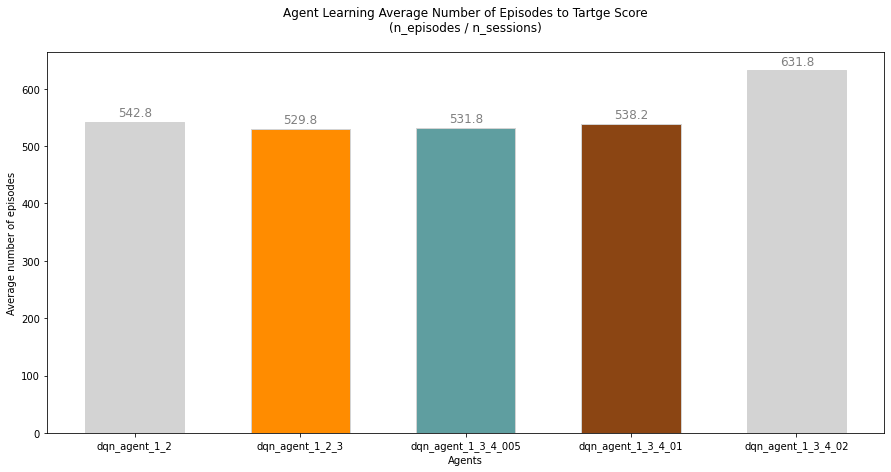

In [24]:
# plot the training avg n_episodes

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

avg_episodes = list()

for agent in training_log.keys():
  data = training_log[agent]
  avg_episodes.append(data.groupby(['agent', 'session'])['episode']
                      .count()
                      .groupby(level = 0)
                      .mean()
                      .rename('avg_episodes')
                      .reset_index()
                      .assign(color = (colors[agent] if agent in colors.keys() else colors['other']))
                     )
data = pd.concat(avg_episodes, axis = 0, ignore_index=True)
bars = ax.bar(x = data['agent'], 
              height = data['avg_episodes'], 
              color = data['color'], width = 0.6, edgecolor = 'LightGray')

for i in range(data.shape[0]):
  y = data.iloc[i]['avg_episodes']
  ax.text(x = i - 0.1, y = y + 10, s = '{}'.format(y), color = 'gray', 
          fontdict = {'fontsize': 12}
         )

# ax.bar_label(bars, data['avg_episodes'], color = 'DarkOrange') 
    
ax.set_ylabel('Average number of episodes')
ax.set_xlabel('Agents')

title = "Agent Learning Average Number of Episodes to Tartge Score\n(n_episodes / n_sessions)\n"
ax.set_title(title)
plt.show()

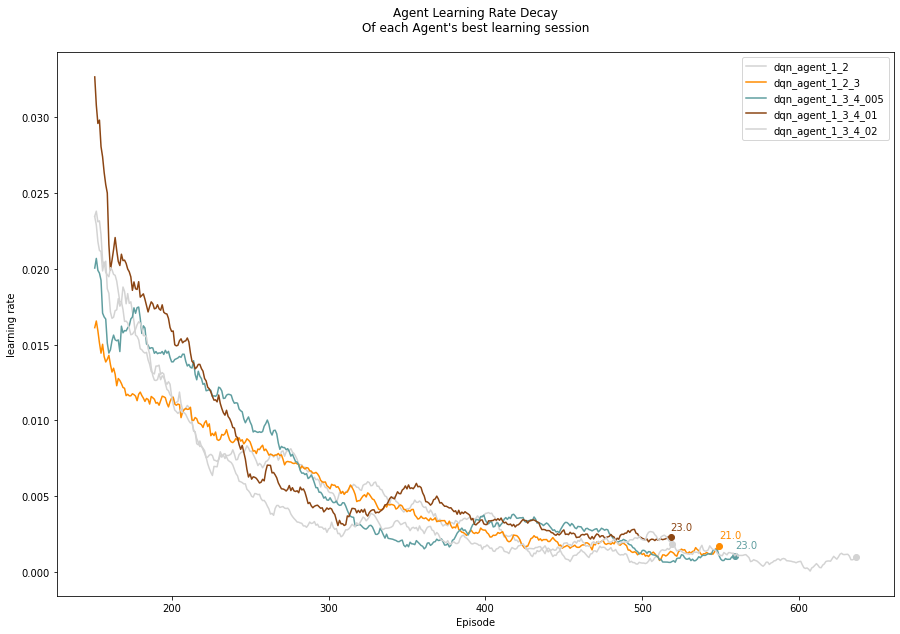

In [25]:
# plot agents best session learning rate

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

for agent in training_log.keys():
  agents = list(training_log.keys())
    
  data = training_log[agent]
  data = data[data['session'] == best_agent[agent]['session']]

  mean_data = data['score'].rolling(window = 100).mean()[100:]
  
  learnig_rte = ((mean_data - mean_data.shift(1)) / mean_data).rolling(window = 50).mean()

  color = colors['other']
  if agent in colors.keys():
    color = colors[agent]
    ax.text(x = data['episode'][-1:], y = learnig_rte.iloc[-1:] + 0.0005, 
          s = best_agent[agent]['score'], color = color)
    
  ax.plot(data['episode'][100:], learnig_rte, color = color, label = agent)
  ax.scatter(x = data['episode'][-1:], y = learnig_rte.iloc[-1:], color = color)
  
ax.set_ylabel('learning rate')
ax.set_xlabel('Episode')
ax.legend()

title = "Agent Learning Rate Decay\nOf each Agent's best learning session\n"
ax.set_title(title)

plt.show()

### Persist Learning Data

I save the output to disk, to use it the in analysis notebook

#### Learning Data

In [28]:
dir_path = os.path.abspath("learning_data")

In [31]:
for agent in list(training_log.keys()):
  file_name = "{}_learning_data.csv".format(agent)
  file_path = os.path.join(dir_path, file_name)
  
  training_log[agent].to_csv(file_path, index = False)

#### Best Agent Session

In [37]:
ba = pd.DataFrame(data = [best_agent[agent] for agent in best_agent.keys()], 
                  index = best_agent.keys()
                 ).reset_index()
ba

,index,score,episode,session
0,dqn_agent_1_2,23.0,503,3
1,dqn_agent_1_2_3,21.0,505,0
2,dqn_agent_1_3_4_005,23.0,499,4
3,dqn_agent_1_3_4_01,23.0,423,2
4,dqn_agent_1_3_4_02,23.0,582,1


In [35]:
file_name = "best_agent_learning_session_data.csv"
file_path = os.path.join(dir_path, file_name)

In [38]:
ba.to_csv(file_path, index = False)